In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("dataset.csv")



In [4]:
df.head()

,Time,Temperature,Humidity,Air Quality,Light,Loudness
0,1623781306,37.94,28.94,75,644,106
1,1623781316,37.94,29.00,75,645,145
2,1623781326,37.88,28.88,75,644,146
3,1623781336,37.72,28.94,75,646,139
4,1623781346,37.69,29.19,75,644,155


In [3]:
df.isnull().sum()

Time           0
Temperature    0
Humidity       0
Air Quality    0
Light          0
Loudness       0
dtype: int64

In [ ]:
# Drop duplicate values
df = df.drop_duplicates()

# Drop rows with missing values
df = df.dropna()

# Feature selection (excluding timestamp)
features = ['Temperature', 'Humidity', 'Air Quality', 'Light', 'Loudness']
data = df[features]

print("Data loaded and cleaned successfully!")

In [12]:
# Normalize sensor readings using Min-Max Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=features)

print("Data normalized successfully!")

df_scaled.to_csv("dataset_cleaned.csv",index=False)


Data normalized successfully!


In [4]:
# Split data into training and test sets
X_train, X_test = train_test_split(scaled_data, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (5246, 5)
Test set shape: (1312, 5)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define input shape
input_dim = X_train.shape[1]

# Encoder: Compress data
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation="relu")(input_layer)
encoded = Dense(16, activation="relu")(encoded)
encoded = Dense(8, activation="relu")(encoded)  # Bottleneck layer

# Decoder: Reconstruct data
decoded = Dense(16, activation="relu")(encoded)
decoded = Dense(32, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded)  # Output layer

# Define Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile model
autoencoder.compile(optimizer="adam", loss="mse")

# Print model summary
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 5)                 165   

In [6]:
# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,  # Input and output are the same for reconstruction
    epochs=50,         # Number of training iterations
    batch_size=32,     # Number of samples per update
    validation_split=0.1,  # Use 10% of training data for validation
    shuffle=True       # Shuffle data before training
)

print("Autoencoder training complete!")


Epoch 1/50
148/148 [==============================] - 2s 3ms/step - loss: 0.0426 - val_loss: 0.0060
Epoch 2/50
148/148 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 3/50
148/148 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/50
148/148 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 8.4639e-04
Epoch 5/50
148/148 [==============================] - 0s 3ms/step - loss: 7.5011e-04 - val_loss: 6.0317e-04
Epoch 6/50
148/148 [==============================] - 1s 4ms/step - loss: 5.9595e-04 - val_loss: 5.4591e-04
Epoch 7/50
148/148 [==============================] - 0s 3ms/step - loss: 5.3263e-04 - val_loss: 5.2771e-04
Epoch 8/50
148/148 [==============================] - 0s 3ms/step - loss: 5.0493e-04 - val_loss: 4.8083e-04
Epoch 9/50
148/148 [==============================] - 0s 3ms/step - loss: 4.8486e-04 - val_loss: 4.6059e-04
Epoch 10/50
148/148 [==============================] - 0

In [7]:
# Predict the test set
X_test_pred = autoencoder.predict(X_test)

# Compute reconstruction error (Mean Absolute Error)
reconstruction_error = np.mean(np.abs(X_test - X_test_pred), axis=1)

print("Reconstruction error computed successfully!")


41/41 [==============================] - 0s 2ms/step
Reconstruction error computed successfully!


In [8]:
# Define threshold using the 95th percentile of reconstruction errors
threshold = np.percentile(reconstruction_error, 95)

# Classify anomalies
anomalies = reconstruction_error > threshold

print(f"Anomaly detection threshold: {threshold}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")


Anomaly detection threshold: 0.011806449356070241
Number of anomalies detected: 66


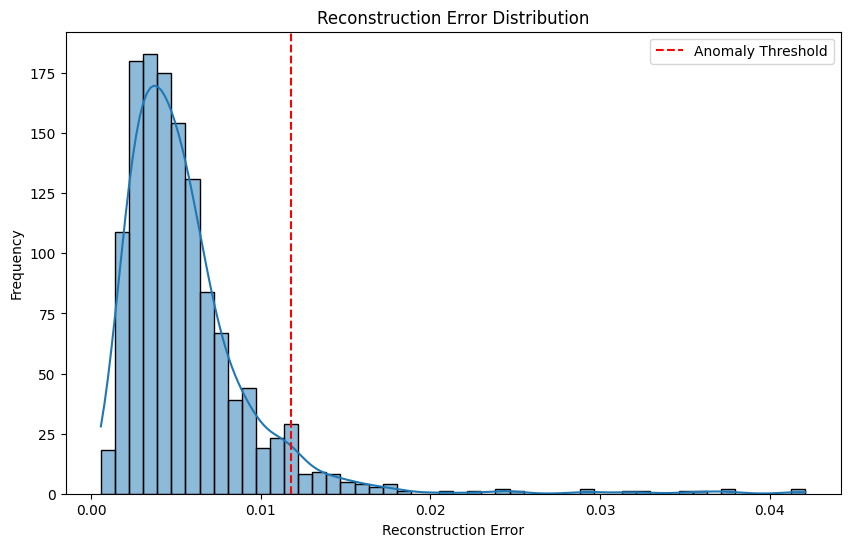

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot reconstruction error
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_error, bins=50, kde=True)
plt.axvline(threshold, color="red", linestyle="dashed", label="Anomaly Threshold")
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [10]:
# Save trained model
autoencoder.save("autoencoder_model.h5")

print("Model saved successfully!")


Model saved successfully!
